In [ ]:
# @title ###### Licensed to the Apache Software Foundation (ASF), Version 2.0 (the "License")

# Licensed to the Apache Software Foundation (ASF) under one
# or more contributor license agreements. See the NOTICE file
# distributed with this work for additional information
# regarding copyright ownership. The ASF licenses this file
# to you under the Apache License, Version 2.0 (the
# "License"); you may not use this file except in compliance
# with the License. You may obtain a copy of the License at
#
#   http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing,
# software distributed under the License is distributed on an
# "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY
# KIND, either express or implied. See the License for the
# specific language governing permissions and limitations
# under the License

# Ensemble model using an image captioning and ranking example

A single machine learning  model may not always be the perfect solution for a give task. Oftentimes, machine learning model tasks involve aggregating mutliple models together to produce one optimal predictive model and boost performance. 
 

In this notebook, we will shows you an example on how to implement a cascade model in Beam using the [RunInference API](https://beam.apache.org/documentation/sdks/python-machine-learning/). The RunInference API enables you to run your Beam transfroms as part of your pipeline for optimal machine learning inference in beam.     

Make sure to checkout this [notebook](https://colab.research.google.com/drive/111USL4VhUa0xt_mKJxl5nC1YLOC8_yF4?usp=sharing#scrollTo=746b67a7-3562-467f-bea3-d8cd18c14927) to get familiar with the RunInference API.

## Use case: Image captioning with cascade models 

Image captioning has various different applications such as image indexing for information retreival, usage in virtual assistants and many other natural language processing applications.

We want to use beam to generate captions on a a large set of images. Beam is the ideal tool to handle this. We will use two models for this task:

* [BLIP](https://github.com/salesforce/BLIP): Used to generate a set of candidate captions for a given image. 
* [CLIP](https://github.com/openai/CLIP): Used to rank the generated captions by the order in which they better represent the the given image.

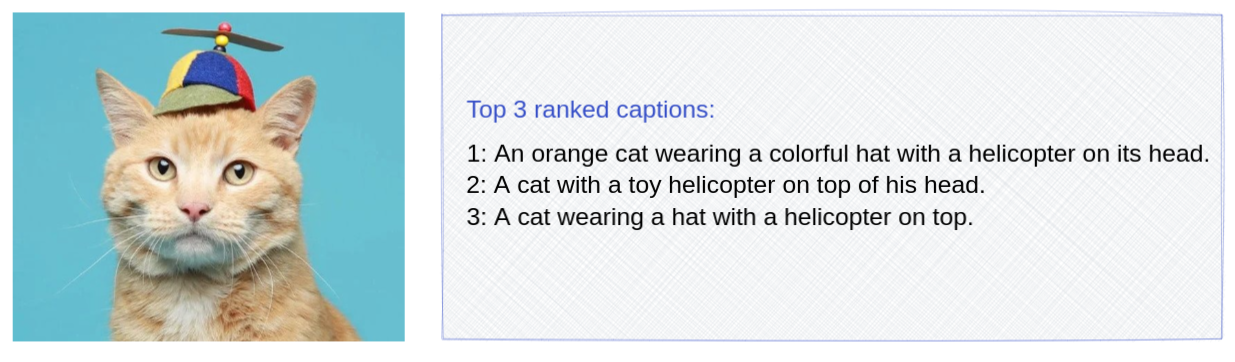

The steps needed to build this pipeline can be summarized as follows:
* Read the images.
* Preprocess the images for caption generation for inference with the BLIP model.
* Inference with BLIP to generate a list of caption candidates . 
* Aggregate the generated captions with their source image.
* Preprocess the aggregated image-caption pair to rank them with CLIP.
* Inference wih CLIP to generated the caption ranking. 
* Print the image names and the captions sorted according to their ranking


The following image illustrates the steps that will be followed in the inference pipelines in more details:

In [ ]:
#@title Diagram
from IPython.display import Image
Image(url='https://storage.googleapis.com/apache-beam-samples/image_captioning/beam_ensemble_diagram.png', width=2000)

## Dependencies

The RunInference library is available in Apache Beam version **2.40** or later. 

In [ ]:
!pip install --upgrade pip --quiet
!pip install transformers==4.15.0 --quiet
!pip install timm==0.4.12 --quiet
!pip install ftfy==6.1.1 --quiet
!pip install spacy==3.4.1 --quiet
!pip install fairscale==0.4.4 --quiet
!pip install apache_beam[gcp]>=2.40.0  

# restart the runtime in order to use newly installed versions
exit() 

     |████████████████████████████████| 2.0 MB 4.7 MB/s 
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 34.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.5/163.5 kB 18.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 880.6/880.6 kB 62.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 75.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 377.0/377.0 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.4/235.4 kB 7.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependenc

In [ ]:
import requests
import os 
import io
from io import BytesIO
from typing import Iterator
from typing import Iterable
from typing import Tuple
from typing import Optional
from typing import Dict
from typing import List
from typing import Any

import apache_beam as beam
from apache_beam.ml.inference.base import PredictionResult
from apache_beam.options.pipeline_options import PipelineOptions
from apache_beam.options.pipeline_options import SetupOptions
from apache_beam.ml.inference.base import KeyedModelHandler
from apache_beam.ml.inference.base import PredictionResult
from apache_beam.ml.inference.base import RunInference
from apache_beam.ml.inference.pytorch_inference import PytorchModelHandlerTensor
from apache_beam.ml.inference.pytorch_inference import PytorchModelHandlerKeyedTensor
from transformers import CLIPProcessor
from transformers import CLIPTokenizer
from transformers import CLIPModel
from transformers import CLIPConfig
from transformers import CLIPFeatureExtractor
import torch
from torchvision import transforms
from torchvision.transforms.functional import InterpolationMode
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

### CLIP

In [ ]:
! git lfs install
! git clone https://huggingface.co/openai/clip-vit-base-patch32

Error: Failed to call git rev-parse --git-dir --show-toplevel: "fatal: not a git repository (or any of the parent directories): .git\n"
Git LFS initialized.
Cloning into 'clip-vit-base-patch32'...
remote: Enumerating objects: 48, done.
remote: Counting objects: 100% (48/48), done.
remote: Compressing objects: 100% (28/28), done.
remote: Total 48 (delta 22), reused 42 (delta 19), pack-reused 0
Unpacking objects: 100% (48/48), done.
Filtering content: 100% (3/3), 1.69 GiB | 91.86 MiB/s, done.


In [ ]:
# CLIP model and component configs paths
clip_feature_extractor_config_path = '/content/clip-vit-base-patch32/preprocessor_config.json'
clip_tokenizer_vocab_config_path = '/content/clip-vit-base-patch32/vocab.json'
clip_merges_config_path = '/content/clip-vit-base-patch32/merges.txt'
clip_model_config_path = '/content/clip-vit-base-patch32/config.json'
clip_state_dict_path = '/content/clip-vit-base-patch32/pytorch_model.bin'


### BLIP

In [ ]:
!git clone https://github.com/salesforce/BLIP
%cd /content/BLIP

Cloning into 'BLIP'...
remote: Enumerating objects: 274, done.
remote: Counting objects: 100% (109/109), done.
remote: Compressing objects: 100% (29/29), done.
remote: Total 274 (delta 89), reused 80 (delta 80), pack-reused 165
Receiving objects: 100% (274/274), 7.67 MiB | 26.26 MiB/s, done.
Resolving deltas: 100% (146/146), done.
/content/BLIP


In [ ]:
from BLIP.models.blip import blip_decoder

!gdown 'https://storage.googleapis.com/sfr-vision-language-research/BLIP/models/model*_base_caption.pth'
# The blip model is saved as a checkoint, load it and save it as a state dict since RunInference required 
# a state dict for model instantiation 
blip_state_dict_path = '/content/BLIP/blip_state_dict.pth'
torch.save(torch.load('/content/BLIP/model*_base_caption.pth')['model'], blip_state_dict_path)

Downloading...
From: https://storage.googleapis.com/sfr-vision-language-research/BLIP/models/model*_base_caption.pth
To: /content/BLIP/model*_base_caption.pth
100% 896M/896M [00:04<00:00, 193MB/s] 


## I/O helper functions 

In [ ]:
class ReadImagesFromUrl(beam.DoFn):
  """
  Read an image from a given url and return a tuple of the images_url
  and image data.
  """
  def process(self, element: str) -> Tuple[str, Image.Image]:
    response = requests.get(element)
    image = Image.open(BytesIO(response.content)).convert('RGB')
    return [(element, image)]


class FormatCaptions(beam.DoFn):
  """
  Print the image name and it's most relevant captions after CLIP ranking.
  """
  def __init__(self, number_of_top_captions: int):
    self._number_of_top_captions = number_of_top_captions

  def process(self, element: Tuple[str, List[str]]):
    image_url, caption_list = element
    caption_list = caption_list[:self._number_of_top_captions]
    img_name = os.path.basename(image_url).rsplit('.')[0]
    print(f'Image: {img_name}')
    print(f'\tTop {self._number_of_top_captions} captions ranked by CLIP:')
    for caption_rank, caption_prob_pair in enumerate(caption_list):
      print(f'\t\t{caption_rank+1}: {caption_prob_pair[0]}. (Caption probability: {caption_prob_pair[1]:.2f})')
    print('\n')

## Intermediate Processing functions

Here we define the preprocessing and postprocessing function for each of the models.

> ℹ️ We use `DoFn.setup()` to prepare the instance for processing bundles of elements by initializing and cache the processing transform resources. As such, we avoid unnecessary re-initializations on every invocation to the processing method.

### BLIP

In [ ]:
class PreprocessBLIPInput(beam.DoFn):

  """
  Process the raw image input to a format suitable for BLIP Inference. The processed
  images are duplicated to the number of desired captions per image. 

  Preprocessing transformation taken from: 
  https://github.com/salesforce/BLIP/blob/d10be550b2974e17ea72e74edc7948c9e5eab884/predict.py
  """

  def __init__(self, captions_per_image: int):
    self._captions_per_image = captions_per_image

  def setup(self):
    
    # Initialize image transformer
    self._transform = transforms.Compose([
      transforms.Resize((384, 384),interpolation=InterpolationMode.BICUBIC),
      transforms.ToTensor(),
      transforms.Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711))
    ])

  def process(self, element):
    image_url, image = element 
    # This should be changed when this ticket is resolved https://github.com/apache/beam/issues/21863
    preprocessed_img = self._transform(image).unsqueeze(0)
    preprocessed_img = preprocessed_img.repeat(self._captions_per_image, 1, 1, 1)
    # Parse the processed input to a dictionary to a format suitable for RunInference
    preprocessed_dict = {'inputs': preprocessed_img}

    return [(image_url, preprocessed_dict)]

class PostprocessBLIPOutput(beam.DoFn):
  """
  Process the PredictionResult to get the generated image captions
  """
  def process(self, element : Tuple[str, Iterable[PredictionResult]]):
    image_url, prediction = element 

    return [(image_url, prediction.inference)]

###CLIP

In [ ]:
class PreprocessCLIPInput(beam.DoFn):

  """
  Process the image-caption pair to a format suitable for CLIP inference. 

  After grouping the raw images with the generated captions, we need to 
  preprocess them before passing them to the ranking stage (CLIP model).
  """

  def __init__(self,
               feature_extractor_config_path: str,
               tokenizer_vocab_config_path: str,
               merges_file_config_path: str):

    self._feature_extractor_config_path = feature_extractor_config_path
    self._tokenizer_vocab_config_path = tokenizer_vocab_config_path 
    self._merges_file_config_path = merges_file_config_path


  def setup(self):
    
    # Initialize the CLIP feature extractor 
    feature_extractor_config = CLIPConfig.from_pretrained(self._feature_extractor_config_path)
    feature_extractor = CLIPFeatureExtractor(feature_extractor_config)

    # Initialize the CLIP tokenizer
    tokenizer = CLIPTokenizer(self._tokenizer_vocab_config_path,
                              self._merges_file_config_path)
    
    # Initialize the CLIP processor used to process the image-caption pair 
    self._processor = CLIPProcessor(feature_extractor=feature_extractor,
                                    tokenizer=tokenizer)

  def process(self, element: Tuple[str, Dict[str, List[Any]]]):

    image_url, image_captions_pair = element 
    # Unpack the image and captions after grouping them with 'CoGroupByKey()' 
    image = image_captions_pair['image'][0]
    captions = image_captions_pair['captions'][0]
    preprocessed_clip_input = self._processor(images = image,
                                              text = captions,
                                              return_tensors="pt",
                                              padding=True)
    
    image_url_caption_pair = (image_url, captions)
    return [(image_url_caption_pair, preprocessed_clip_input)]


class RankCLIPOutput(beam.DoFn):
  """
  Process the output of CLIP to get the captions sorted by ranking order.

  The logits are the output of the CLIP model. Here, we apply a softmax activation
  function to the logits to get the probabilistic distribution of the relevance
  of each caption to the target image. After that, we sort the captions in descending
  order with respect to the probabilities as a caption-probability pair. 
  """

  def process(self, element : Tuple[Tuple[str, List[str]], Iterable[PredictionResult]]):
    (image_url, captions), prediction = element
    prediction_results = prediction.inference
    prediction_probs = prediction_results.softmax(dim=-1).cpu().detach().numpy()
    ranking = np.argsort(-prediction_probs)
    sorted_caption_prob_pair = [(captions[idx], prediction_probs[idx]) for idx in ranking]

    return [(image_url, sorted_caption_prob_pair)]

## Model handlers

> ℹ️ Note that we will use a `KeyedModelHandler` for both models to attach a key to the general `ModelHandler`. The key is used to keep a reference of which image the inference is assoicated with, and it used in our post processing steps. In our case, we're using the `image_url` as the key.

In [ ]:
class PytorchNoBatchModelHandlerKeyedTensor(PytorchModelHandlerKeyedTensor):
      """Wrapper to PytorchModelHandler to limit batch size to 1.
    The caption strings generated from BLIP tokenizer may have different
    lengths, which doesn't work with torch.stack() in current RunInference
    implementation since stack() requires tensors to be the same size.
    Restricting max_batch_size to 1 means there is only 1 example per `batch`
    in the run_inference() call.
    """
    # This should be changed when this ticket is resolved https://github.com/apache/beam/issues/21863
      def batch_elements_kwargs(self):
          return {'max_batch_size': 1}

> ℹ️ Note that we will use a `KeyedModelHandler` for both models to attach a key to the general `ModelHandler`. The key will be used for aggregation transforms of different inputs. 

## BLIP

In [ ]:
MAX_CAPTION_LENGTH = 80
MIN_CAPTION_LENGTH = 10
# Increasing beam search can improve the quality of the captions but results in
# more compute time
NUM_BEAMS = 1


In [ ]:
class BLIPWrapper(torch.nn.Module):
  """
   Wrapper around the BLIP model to overwrite the default "forward" method with the "generate" since BLIP uses the 
  "generate" method to produce the image captions.
  """
  
  def __init__(self, base_model: blip_decoder, num_beams: int, max_length: int,
                min_length: int):
    super().__init__()
    self._model = base_model()
    self._num_beams = num_beams
    self._max_length = max_length
    self._min_length = min_length

  def forward(self, inputs: torch.Tensor):
    # squeeze because RunInference adds an extra dimension, which is empty
    # This should be changed when this ticket is resolved https://github.com/apache/beam/issues/21863
    inputs = inputs.squeeze(0)
    captions = self._model.generate(inputs,
                                    sample=True,
                                    num_beams=self._num_beams,
                                    max_length=self._max_length,
                                    min_length=self._min_length)
    return [captions]

  def load_state_dict(self, state_dict: dict):
    self._model.load_state_dict(state_dict)


BLIP_model_handler = PytorchNoBatchModelHandlerKeyedTensor(
    state_dict_path=blip_state_dict_path,
    model_class=BLIPWrapper,
    model_params={'base_model': blip_decoder, 'num_beams': NUM_BEAMS,
                  'max_length': MAX_CAPTION_LENGTH, 'min_length': MIN_CAPTION_LENGTH},
    device='GPU')

BLIP_keyed_model_handler = KeyedModelHandler(BLIP_model_handler)

## CLIP

In [ ]:
class CLIPWrapper(CLIPModel):

  def forward(self, **kwargs: Dict[str, torch.Tensor]):
    # squeeze because RunInference adds an extra dimension, which is empty
    # This should be changed when this ticket is resolved https://github.com/apache/beam/issues/21863
    kwargs = {key: tensor.squeeze(0) for key, tensor in kwargs.items()}
    output = super().forward(**kwargs)
    logits = output.logits_per_image
    return logits


CLIP_model_handler = PytorchNoBatchModelHandlerKeyedTensor(
    state_dict_path=clip_state_dict_path,
    model_class=CLIPWrapper,
    model_params={'config': CLIPConfig.from_pretrained(clip_model_config_path)},
    device='GPU')

CLIP_keyed_model_handler = KeyedModelHandler(CLIP_model_handler)


## Specify the images to display

In [ ]:
images_url = ['https://storage.googleapis.com/apache-beam-samples/image_captioning/hamster_tea.jpg',
              'https://storage.googleapis.com/apache-beam-samples/image_captioning/potato_field.jpg',
              'https://storage.googleapis.com/apache-beam-samples/image_captioning/eiffel_tower_ballet_dancer.jpg']

Let's visualize the images that we will use for captioning 

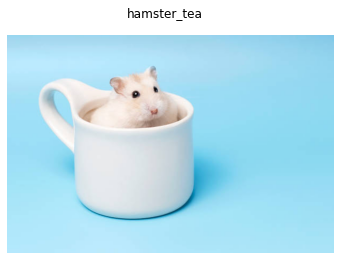

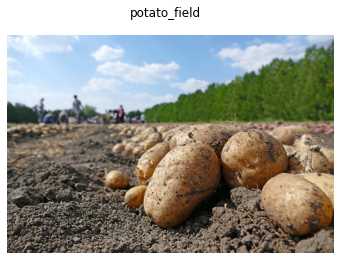

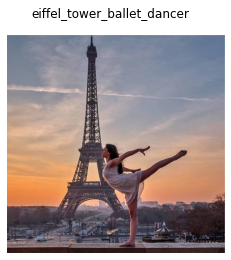

In [ ]:
for image_url in images_url:
  response = requests.get(image_url)
  image = Image.open(BytesIO(response.content)).convert('RGB')
  fig = plt.figure()
  title = os.path.basename(image_url).rsplit('.')[0]
  fig.suptitle(title, fontsize=12)
  plt.axis('off')
  plt.imshow(image)


## Initialize pipeline run parameters 

In [ ]:
# Number of Generated captions per image
NUM_CAPTIONS_PER_IMAGE = 10

# Top captions to display
NUM_TOP_CAPTIONS_TO_DISPLAY = 3


## Run pipeline

> ℹ️ Note that we are using raw images from the `read_images` pipeline as input to both models. This is done because each model needs to preprocess the raw images differently (i.e. they require a different embedding representation for image captioning and image/captions pair ranking resp.).

> ℹ️ We use `CoGroupByKey` to aggregate the raw images with the generated captions by their key (i.e. the image url). This process produces a tuple of image-captions pairs that is then passed to the CLIP transform and used for ranking.

In [ ]:
with beam.Pipeline() as pipeline:

  read_images = (
            pipeline 
            | "ReadUrl" >> beam.Create(images_url)
            | "ReadImages" >> beam.ParDo(ReadImagesFromUrl()))

  blip_caption_generation = (
            read_images
            | "PreprocessBlipInput" >> beam.ParDo(PreprocessBLIPInput(NUM_CAPTIONS_PER_IMAGE)) 
            | "GenerateCaptions" >> RunInference(BLIP_keyed_model_handler)
            | "PostprocessCaptions" >> beam.ParDo(PostprocessBLIPOutput()))

  clip_captions_ranking = (
            ({'image' : read_images, 'captions': blip_caption_generation})
            | "CreateImageCaptionPair" >> beam.CoGroupByKey()
            | "PreprocessClipInput" >> beam.ParDo(
                PreprocessCLIPInput(
                    clip_feature_extractor_config_path,
                    clip_tokenizer_vocab_config_path,
                    clip_merges_config_path))
            | "GetRankingLogits" >> RunInference(CLIP_keyed_model_handler)
            | "RankClipOutput" >> beam.ParDo(RankCLIPOutput()))

  clip_captions_ranking | "FormatCaptions" >> beam.ParDo(FormatCaptions(NUM_TOP_CAPTIONS_TO_DISPLAY))
  

Image: hamster_tea
	Top 3 captions ranked by CLIP:
		1: a small white hamster inside of a mug. (Caption probability: 0.31)
		2: the hamster is in a white mug on a blue surface. (Caption probability: 0.24)
		3: a small hamster in a coffee cup. (Caption probability: 0.22)


Image: potato_field
	Top 3 captions ranked by CLIP:
		1: several potatoes are in the ground with a blue sky. (Caption probability: 0.64)
		2: a bunch of potatoes are sitting in the dirt. (Caption probability: 0.09)
		3: potato plants sprouts on muddy ground near forest. (Caption probability: 0.09)


Image: eiffel_tower_ballet_dancer
	Top 3 captions ranked by CLIP:
		1: a woman practices ballet in front of the eiffel tower. (Caption probability: 0.48)
		2: a dancer is practicing in front of the eiffel tower. (Caption probability: 0.26)
		3: a woman is doing ballet next to the eiffel tower. (Caption probability: 0.17)




# References

* [RunInference API](https://beam.apache.org/documentation/sdks/python-machine-learning/) -- an official guide to the RunInference API.
* [RunInference Demo](https://colab.research.google.com/drive/10iPQTCmaLJL4_OohS00R9Wmor6d57JkS#scrollTo=ZVtBsKDgW1dl) -- a demo on ensemble model in colab
* [The advantages of having a DAG and what it unlocks for you](https://beam.apache.org/documentation/dsls/dataframes/differences-from-pandas) -- A guide on the advantages of using a Beam DAG for ML workflow orchestration and inference. 